In [14]:
using CausalityTools, DynamicalSystemsBase, Plots, Distributions, Measures

# Tutorial: predictive asymmetry test

### Defining a dynamical system and generating time series

Defining a set of unidirectionally coupled logistic maps

In [9]:
function eom_logistic2(dx, x, p, n)
    c_xy, r₁, r₂, σ = (p...,)
    ξ = rand() 
    x, y = x[1], x[2]
    f_xy = (y +  (c_xy*(x + σ*ξ)/2) ) / (1 + (c_xy/2)*(1+σ))

    dx[1] = r₁ * x * (1 - x)
    dx[2] = r₂ * (f_xy) * (1 - f_xy)
    return
end

eom_logistic2 (generic function with 1 method)

Create a function that returns an instance of a `DynamicalSystems.DiscreteDynamicalSystem`.

In [11]:
function logistic2(u₀, c_xy, r₁, r₂, σ)
    p = [c_xy, r₁, r₂, σ]
    DiscreteDynamicalSystem(eom_logistic2_unidir, u₀, p)
end

logistic2(;u₀ = rand(2), c_xy = 0.1, r₁ = 3.78, r₂ = 3.66, σ = 0.05) =
    logistic2(u₀, c_xy, r₁, r₂, σ)

logistic2 (generic function with 2 methods)

Initialise a system

In [12]:
system = logistic2(c_xy = 0.5, r₁ = 3.7, r₂ = 3.8)

2-dimensional discrete dynamical system
 state:       [0.47565, 0.809504]
 e.o.m.:      eom_logistic2_unidir
 in-place?    true
 jacobian:    ForwardDiff
 parameters:  [0.5, 3.7, 3.8, 0.05]

Generate orbit (time series).

In [30]:
npts = 300
orbit = trajectory(system, 300, Ttr = 1000); x, y = columns(orbit);

Plot it

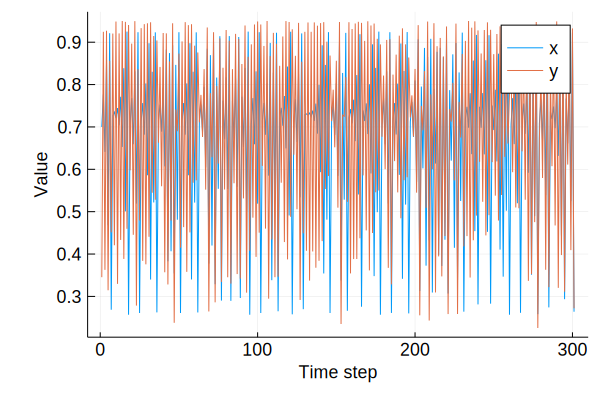

In [31]:
p = plot(xlabel = "Time step", ylabel = "Value", tickfont = font(12), guidefont = font(12), left_margin = 8mm, bottom_margin = 8mm, legendfont = font(12))
plot!(p, [columns(orbit)...], label = ["x", "y"])

Okay, so we have some time series

## PredictiveAsymmetryTest

Let's first investigate the documentation for the test

In [28]:
?PredictiveAsymmetryTest

search: PredictiveAsymmetryTest predictive_asymmetry



```
PredictiveAsymmetryTest(predictive_test::CausalityTest)
```

The parameters for a predictive asymmetry causality test [1]. 

## Mandatory keywords

  * **`predictive_test`**: An instance of a predictive causality test that explicitly    uses prediction lags (e.g. [`VisitationFrequencyTest`](@ref) or    [`TransferOperatorGridTest`](@ref)).

## About the prediction lags

The prediction lags in the predictive causality test must consist of `n` negative  integers and `n` positive integers that are symmetric around zero. 

In other words, negative lags  must exactly match the positive lags but with opposite  sign. The zero lag can be included, but will be ignored, so it is possible to give  ranges too.

## Examples

```julia
test_visitfreq = VisitationFrequencyTest(ηs = [-5, -4, -2, -1, 0, 1, 2, 4, 5])
test_transferoperator = TransferOperatorGridTest(ηs = -3:3)

# Note that `predictive_test` is a *mandatory* keyword.
PredictiveAsymmetryTest(predictive_test = test_visitfreq)
PredictiveAsymmetryTest(predictive_test = test_transferoperator)
```

## References

1. Diego, David, Kristian Agasøster Haaga, Jo Brendryen, and Bjarte Hannisdal.   A simple test for causal asymmetry in complex systems. In prep.


## Transfer entropy test

Okay, so we first need to define a transfer entropy test to use for the prediction. For this, we have several choices, but for the demonstration, we'll stick to the `TransferOperatorGridTest`, which estimates probabilities from an approximation to the transfer operator (Diego et al., 2019).

In [29]:
?TransferOperatorGridTest

search: TransferOperatorGridTest TransferOperatorGrid



```
TransferOperatorGridTest(k::Int = 1, l::Int = 1, m::Int = 1, n::Int = 1, 
    τ::Int = 1, b = 2, estimator::TransferOperatorGrid = TransferOperatorGrid(), 
    binning_summary_statistic::Function = StatsBase.mean,
    binning::RectangularBinning, ηs)
```

The parameters for a transfer entropy test using the `TransferOperatorGrid` estimator [1].

## Mandatory keyword arguments

  * **`binning::RectangularBinning`**: An instance of a [`RectangularBinning`](@ref) that dictates    how the delay embedding is discretized.
  * **`ηs`**: The prediction lags (that gos into the $T_{f}$ component of the embedding).

## Optional keyword arguments

  * **`k::Int`**: The dimension of the $T_{f}$ component of the embedding.
  * **`l::Int`**: The dimension of the $T_{pp}$ component of the embedding.
  * **`m::Int`**: The dimension of the $S_{pp}$ component of the embedding.
  * **`n::Int`**: The dimension of the $C_{pp}$ component of the embedding.
  * **`τ::Int`**: The embedding lag. Default is `τ = 1`.
  * **`b`**: Base of the logarithm. The default (`b = 2`) gives the TE in bits.
  * **`estimator::TransferOperatorGrid`**: A `TransferOperatorGrid` estimator instance.
  * **`binning_summary_statistic::Function`**: A summary statistic to summarise the    transfer entropy values if multiple binnings are provided.

## Estimation of the invariant measure

With a `TransferOperatorGridTest`, the first step is to compute an approximation to the  [transfer operator](@ref transfer_operator_rectangular) over the partition elements of a rectangular [discretization](@ref discretization)  of an appropriate [delay reconstruction](@ref custom_delay_reconstruction) of the time  series to be analysed. Transfer entropy is then computed from the [invariant  distribution](@ref invariant_measure_rectangular) arising from the transfer operator. 

## About the delay reconstruction for transfer entropy analysis

Denote the time series for the source process $S$ as $S(t)$, and the time series for  the target process $T$ as $T(t)$, and $C_i(t)$ as the time series for any conditional  processes $C_i$ that also may influence $T$. To compute (conditional) TE, we need a  generalised embedding [3, 4] incorporating all of these processes.

For convenience, define the state vectors

$$
\begin{align}
T_f^{(k)} &= \{(T(t+\eta_k), \ldots, T(t+\eta_2), T(t+\eta_1))\}, \label{eq:Tf} \\
T_{pp}^{(l)} &= \{ (T(t), T(t-\tau_1), T(t-\tau_2), \ldots, T(t - \tau_{l - 1})) \\
S_{pp}^{(m)} &= \{(S(t), S(t-\tau_1), S(t-\tau_2), \ldots, S(t-\tau_{m - 1}))\},\\
C_{pp}^{(n)} &= \{ (C_1(t), C_1(t-\tau_1), \ldots,  C_2(t), C_2(t-\tau_1) \},
\end{align}
$$

where the state vectors $T_f^{(k)}$ contain $k$ future values of the target  variable, $T_{pp}^{(l)}$ contain $l$ present and past values of the target  variable, $S_{pp}^{(m)}$ contain $m$ present and past values of the source  variable, $C_{pp}^{(n)}$ contain a total of $n$ present and past values of any  conditional variable(s).  Combining all variables, we have the generalised embedding 

$$
\begin{align}
\mathbb{E} = (T_f^{(k)}, T_{pp}^{(l)}, S_{pp}^{(m)}, C_{pp}^{(n)})
\end{align}
$$

with a total embedding dimension of $k + l + m + n$.  Here, $\tau$ indicates the [embedding](@ref custom_delay_reconstruction) lag  (in the `VisitationFrequencyTest`, we set $\tau_1 = \tau_2 = \tau_3 = \ldots$), and $\eta$ indicates the prediction lag (the lag of the influence the source  has on the target). 

Hence, in the generalised embedding, only $T_f$ depends on the prediction lag $\eta$,  which is to be determined by the analyst. For transfer entropy analysis, $\eta$ is chosen  to be some positive integer, while for  [predictive asymmetry analysis](@ref predictive_asymmetry),  symmetric negative and positive $\eta$s are used for computing $\mathbb{A}$.  

In terms of this generalised embedding, transfer entropy from a source variable $S$ to a  target variable $T$ with conditioning on variable(s) $C$ is thus defined as 

$$
\begin{align}
TE_{S \rightarrow T|C} = \int_{\mathbb{E}} P(T_f, T_{pp}, S_{pp}, C_{pp}) \log_{2}{\left( \frac{P(T_f | T_{pp}, S_{pp}, C_{pp})}{P(T_f | T_{pp}, C_{pp})}\right)}
\end{align}
$$

Without conditioning, we have 

$$
\begin{align}
TE_{S \rightarrow T} = \int_{\mathbb{E}} P(T_f, T_{pp}, S_{pp}) \log_{2}{\left(\frac{P(T_f | T_{pp}, S_{pp})}{P(T_f | T_{pp})}\right)}
\end{align}
$$

## Low-level estimator

This test uses the `TransferOperatorGrid` estimator on the following low-level method  under the hood. 

  * [`transferentropy(::Any, ::TEVars, ::RectangularBinning, ::TransferEntropyEstimator)`](@ref)

In this estimator, the mapping between variables of the  [generalised embedding](@ref custom_delay_reconstruction) and the marginals during  transfer entropy computation is controlled using a [`TEVars`](@ref)  instance. It is *highly* recommended that you check the documentation for this  method, because it describes the transfer entropy estimation procedure in detail.

## Notes:

  * Use `causality(source, target, params::TransferOperatorGridTest)` for regular    transfer entropy analysis. This method uses only the `k`, `l`, `m` and ignores `n`    when constructing the delay reconstruction.
  * Use `causality(source, target, cond, params::TransferOperatorGridTest)` for conditional    transfer entropy analysis. This method uses the `k`, `l`, `m` *and* `n` when constructing    the delay reconstruction.

## Example

```julia
# Prediction lags
ηs = 1:10
binning = RectangularBinning(10)

# Use defaults, binning and prediction lags are required. 
# Note that `binning` and `ηs` are *mandatory* keyword arguments.
TransferOperatorGridTest(binning = binning, ηs = ηs)

# The other keywords can also be adjusted
TransferOperatorGridTest(k = 1, l = 2, binning = binning, ηs = ηs)
```

## References

1. Diego, David, Kristian Agasøster Haaga, and Bjarte Hannisdal. "Transfer entropy computation   using the Perron-Frobenius operator." Physical Review E 99.4 (2019): 042212.  [https://journals.aps.org/pre/abstract/10.1103/PhysRevE.99.042212](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.99.042212)


Now we have the information we need!

#### Define test

In [33]:
# Maximum prediction 
η_max = 5

# Embedding parameters (3-dimensional embedding)
k, l, m = 1, 1, 1

# Partition
n_subdivisions = floor(Int, npts^(1/(k + l + m + 1)))
bin_scheme = RectangularBinning(n_subdivisions)

#Transfer entropy test with base-2 logarithm, 
te_test = TransferOperatorGridTest(binning = bin_scheme, 
    ηs = -η_max:η_max, b = 2, k = k, l = l, m = m) 

# Predictive asymmetry test based on the transfer entropy test
test = PredictiveAsymmetryTest(predictive_test = te_test)

PredictiveAsymmetryTest{TransferOperatorGridTest}(predictive_test = TransferOperatorGridTest(k = 1, l = 1, m = 1, n = 1, τ = 1, b = 2, estimator = TransferOperatorGrid(), binning_summary_statistic = mean, binning = RectangularBinning(4), ηs = -5:5))

#### Apply test to time series

In [34]:
influence_xtoy = causality(x, y, test)

5-element Array{Float64,1}:
 0.0841187405294912 
 0.24238397862055638
 0.39278347505953715
 0.5459563219258712 
 0.6028904707113814 

In [35]:
influence_ytox = causality(y, x, test)

5-element Array{Float64,1}:
 -0.04880327006908214
 -0.11388715643272285
 -0.19997545963425267
 -0.29352146723425054
 -0.323456930049022  

Plot the predictive asymmetries against the prediction lags.

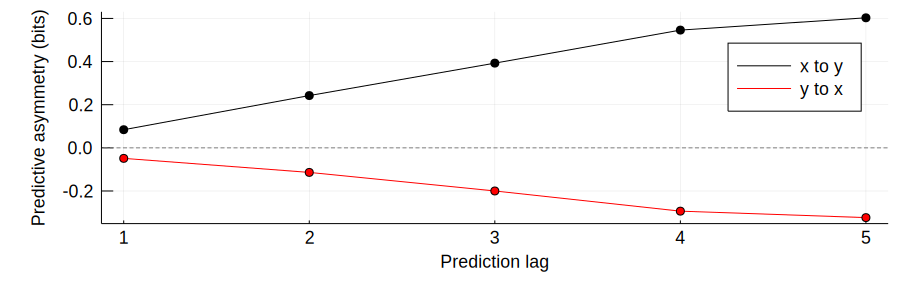

In [36]:
plot(size = (900, 300), bottom_margin = 8mm, left_margin = 8mm, 
    tickfont = font(12), guidefont = font(12), legendfont = font(12), 
    xlabel = "Prediction lag", ylabel = "Predictive asymmetry (bits)"); 
plot!(1:η_max, influence_xtoy, c = :black, label = "x to y"); scatter!(1:η_max, influence_xtoy, c = :black, label = ""); 
plot!(1:η_max, influence_ytox, c = :red, label = "y to x"); scatter!(1:η_max, influence_ytox, c = :red, label = "")
hline!([0], ls = :dash, lc = :grey, label = "")

We find a unidirectional relationship from $X \to Y$, which is the ground truth!